# Electrocardiograms and Neural Networks

We will predict heart arrhythmia using LSTMs and 1-D CNNs.

We will work with the **St. Petersburg INCART 12-lead Arrhythmia Database** ([link](https://physionet.org/static/published-projects/incartdb/st-petersburg-incart-12-lead-arrhythmia-database-1.0.0.zip)).  
The dataset contains **12-lead ECG recordings** sampled at **257 Hz** from 75 subjects, annotated by experts for arrhythmia detection.


In [29]:
# Feel free to add more libraries if you need them
import os
import wfdb
import numpy as np
import pandas as pd
import urllib.request
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.signal
import zipfile
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score,f1_score
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Please remain this random seed unchange for your work's evaluation
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [30]:
# Load database
dataset_url = "https://physionet.org/static/published-projects/incartdb/st-petersburg-incart-12-lead-arrhythmia-database-1.0.0.zip"
dataset_zip_path = "/home/en520-hchennu1/scr4-en520-lmorove1/en520-hchennu1/lab4/st-petersburg-incart-12-lead-arrhythmia-database-1.0.0.zip"
dataset_extract_path = "incartdb_dataset"
if not os.path.exists(dataset_zip_path):
    print("Downloading INCART 12-lead Arrhythmia Database...")
    urllib.request.urlretrieve(dataset_url, dataset_zip_path)
    print("Download completed.")
if not os.path.exists(dataset_extract_path):
    print("Extracting dataset...")
    with zipfile.ZipFile(dataset_zip_path, "r") as zip_ref:
        zip_ref.extractall(dataset_extract_path)
    print("Extraction completed.")

## Explore database

We will primarily use \<patientID>.atr files (patientID being I01, I02, etc.). There are 75 patients with 30-minute recordings each.

For patient 'I48', let's check their signal annotations. Run the code below.

In [31]:
# We provide function for loading an ECG file
def load_ECG_file(path):
    '''
    Input:
        path: Path to the patient file (excluding the extension)
    Output:
        signal: ECG signal (lead I by default)
        symbol: Annotation symbols (heartbeat types)
        index: Annotation indices (sample positions of heartbeats)
    '''
    record = wfdb.rdrecord(path)  # Load ECG signal
    annotation = wfdb.rdann(path, 'atr')  # Load annotations

    signal = record.p_signal[:, 0]  # Select lead I (first lead)
    symbol = annotation.symbol  # Extract annotation symbols
    index = annotation.sample  # Extract annotation indices

    return signal, symbol, index
path_dataset = '/home/en520-jyu146/incartdb_dataset/files/'
signal, symbol, index = load_ECG_file(os.path.join(path_dataset, 'I48'))
print(f'Length of signal: {len(signal)}')  # Length of ECG signal (in samples)
print(f'Annotation symbols (first 10): {symbol[:100]}')  # First 100 annotation symbols
print(f'Annotation indices (first 10): {index[:100]}')  # First 100 annotation indices

Length of signal: 462600
Annotation symbols (first 10): ['N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Annotation indices (first 10): [  209   446   676   906  1102  1231  1555  1778  1979  2110  2339  2528
  2740  2873  3158  3361  3542  3676  3892  4071  4287  4487  4695  4881
  5059  5256  5480  5617  5900  6073  6281  6415  6711  6932  7110  7241
  7461  7642  7862  8069  8285  8477  8663  8796  9113  9308  9498  9630
  9909 10081 10305 10512 10725 10912 11085 11257 11449 11669 11806 12095
 12277 12456 12670 12882 13097 13291 13481 1360

In [32]:
# list of symbols for abnormal beats
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

## Data Visualization

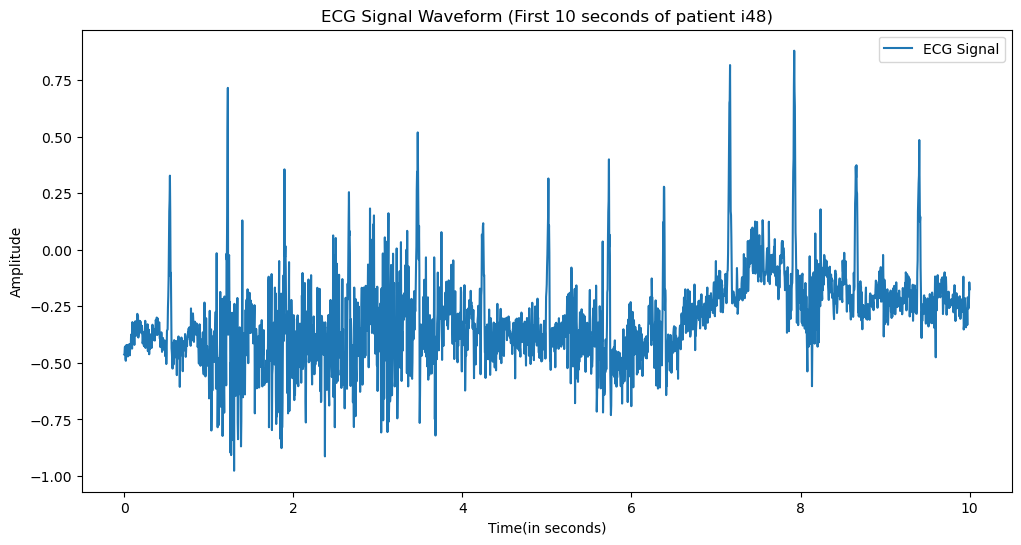

In [33]:
# Plot 1
#patient i48's data as already been extracted in the previous block
sampling_rate = 257
segment_duration = 10
segment_samples = sampling_rate * segment_duration

#getting a random starting point
max_start = len(signal) - segment_samples
start = np.random.randint(0, max_start)
    
end = start + segment_samples
segment = signal[start:end]
time_seconds = np.linspace(0, segment_duration, len(segment))

#plotting
plt.figure(figsize=(12, 6))
plt.plot(time_seconds, segment, label="ECG Signal")
plt.title("ECG Signal Waveform (First 10 seconds of patient i48)")
plt.xlabel("Time(in seconds)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

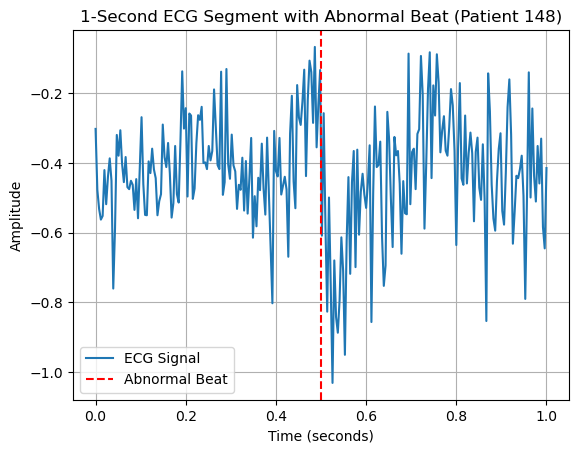

In [34]:
# Plot 2
abnormality_indices = [i for annotation, i in zip(symbol, index) if annotation in abnormal]
random_abnormal_index = np.random.choice(abnormality_indices)

#getting the segment
fs = 257
half_second = fs // 2
start = max(0, random_abnormal_index - half_second)
end = min(len(signal), random_abnormal_index + half_second)
time_segment = np.linspace(0, 1, end - start)

#plotting
plt.plot(time_segment, signal[start:end], label="ECG Signal")
abnormal_point_relative = (random_abnormal_index - start) / (end - start)
plt.axvline(x=abnormal_point_relative, color='r', linestyle='--', label="Abnormal Beat")
plt.title("1-Second ECG Segment with Abnormal Beat (Patient 148)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

## Data Prep

In [35]:
# training patient IDs
pts_train = [f'I{str(i).zfill(2)}' for i in range(1, 31)]
print(pts_train)

# testing patient IDs
pts_test = [f'I{str(i).zfill(2)}' for i in range(31, 41)]
print(pts_test)


['I01', 'I02', 'I03', 'I04', 'I05', 'I06', 'I07', 'I08', 'I09', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'I17', 'I18', 'I19', 'I20', 'I21', 'I22', 'I23', 'I24', 'I25', 'I26', 'I27', 'I28', 'I29', 'I30']
['I31', 'I32', 'I33', 'I34', 'I35', 'I36', 'I37', 'I38', 'I39', 'I40']


In [36]:
def make_dataset(pts, num_sec, fs, abnormal):
    '''
    Create a dataset from ECG signals by extracting specific segments around heartbeats
    and labeling them based on the presence of abnormalities.

    Parameters:
    - pts: List of patient identifiers to load ECG files for processing.
    - num_sec (float): Number of seconds to include before and after each heartbeat in the extracted segment.
    - fs (int): Sampling frequency of the ECG signals, used to calculate the number of samples in each segment.
    - abnormal: List of abbreviations for abnormalities to look for in the ECG signals.

    Returns:
    - X_all (numpy.ndarray): Signal matrix with shape (nbeats, 2 * num_sec * fs).
    - Y_all (numpy.ndarray): Binary labels matrix with shape (nbeats, 1), indicating abnormality presence.
    '''
    X_all = []
    Y_all = []
    path_dataset = '/home/en520-jyu146/incartdb_dataset/files/'
    
    #get segment size from input fs
    segment_size = int(fs * num_sec)
    half_segment = segment_size // 2
    
    for patient in pts:
        signal, symbol, index = load_ECG_file(os.path.join(path_dataset, patient))
        
        # Process only the annotation points, not every sample
        for i, (sym, idx) in enumerate(zip(symbol, index)):
            #extracting the segment
            start = max(0, idx - half_segment)
            end = min(len(signal), idx + half_segment)
            
            #handle bad segment
            if end - start != segment_size:
                continue

            segment = signal[start:end]
            
            label = 1 if sym in abnormal else 0
            
            X_all.append(segment)
            Y_all.append(label)

    X = np.array(X_all)
    Y = np.array(Y_all)
    
    return X, Y

def build_XY(p_signal, df_ann, num_cols, ab_idx, abnormal, num_sec, fs):
    '''
    Build the X (signal segments) and Y (abnormality labels) matrices for each beat.

    Parameters:
    - p_signal: The full ECG signal array.
    - df_ann: DataFrame containing filtered heartbeat annotations.
    - num_cols: The total number of samples per extracted segment.
    - ab_idx: Numpy array containing indices of abnormal beats.
    - abnormal: List of abnormal beat abbreviations.
    - num_sec: Number of seconds before and after each heartbeat for segment extraction.
    - fs: Sampling frequency (Hz).

    Returns:
    - X (numpy.ndarray): Extracted heartbeat signal segments.
    - Y (numpy.ndarray): Binary labels indicating abnormality presence.
    '''
    X = []
    Y = []

    half_segment = num_cols // 2

    #loop to iter through annotations indices
    for i in df_ann.index:
        beat_index = df_ann.loc[i, 'sample']
        beat_symbol = df_ann.loc[i, 'symbol']

        # Calculate segment boundaries
        start = max(0, beat_index - half_segment)
        end = min(len(p_signal), beat_index + half_segment)

        if end - start == num_cols:
            segment = p_signal[start:end]
            label = 1 if beat_symbol in abnormal else 0
            X.append(segment)
            Y.append(label)

    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [ ]:
# Check the abnormal data / normal data ratio for training and testing set
X_train, y_train = make_dataset(pts_train, 2, 257, abnormal)
train_ratio = np.sum(y_train == 1)/np.sum(y_train == 0)

X_test, y_test = make_dataset(pts_test, 2, 257, abnormal)
test_ratio = np.sum(y_test == 1)/np.sum(y_test == 0)

print(f'Ratio for training data is {train_ratio:.2f}\nRatio for testing data is {test_ratio:.2f}')

Ratio for training data is 0.15
Ratio for testing data is 0.23


## Feature Extraction

In [38]:
def extract_features(X):
    '''
    Extracts time-frequency features from ECG segments using Short-Time Fourier Transform (STFT).

    Parameters:
    - X (numpy.ndarray): Input data matrix of shape (N, D), where
      N = number of segments, D = number of samples per segment.

    Returns:
    - X_features (numpy.ndarray): Feature matrix of shape (N, Time, Frequency).
    '''
    N, D = X.shape
    X_features = []
    
    #getting STFT from each segment
    for i in range(N):
        #iterate through patients ecg segements
        segment = X[i, :]
        frequencies, times, Sxx = scipy.signal.spectrogram(segment,fs=257, nperseg=64, noverlap=32, nfft=128,  detrend='constant', return_onesided=True,scaling='density')
        X_features.append(Sxx.T)
    
    X_features = np.array(X_features)
    
    return X_features

# Feature extraction for training and testing datasets
F_train = extract_features(X_train)
F_test = extract_features(X_test)

# Output the shape of extracted features
print(f"F_train shape: {F_train.shape}, F_test shape: {F_test.shape}")

F_train shape: (71165, 15, 65), F_test shape: (25793, 15, 65)


## Distribution and Compensation for Imbalance

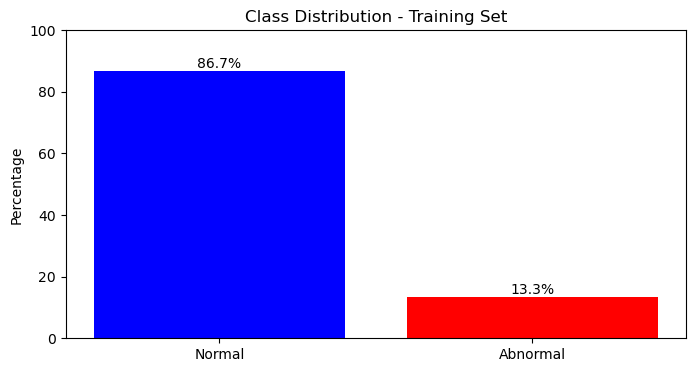

In [39]:
def explain_class_numbers(labels, dataset_name):
    unique_classes, class_counts = np.unique(labels, return_counts=True)
    total_samples = len(labels)
    percentages = class_counts / total_samples * 100
    
    plt.figure(figsize=(8, 4))
    plt.bar(['Normal', 'Abnormal'], percentages, color=['blue', 'red'])
    plt.title(f'Class Distribution - {dataset_name}')
    plt.ylabel('Percentage')
    
    for i, percentage in enumerate(percentages):
        plt.text(i, percentage + 1, f'{percentage:.1f}%', ha='center')
    
    plt.ylim(0, 100)
    plt.show()

explain_class_numbers(y_train, "Training Set")

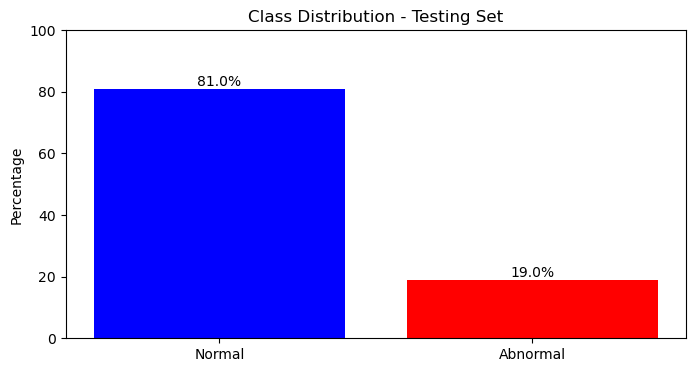

In [ ]:
explain_class_numbers(y_test, "Testing Set")

## Distribution and Compensation for Imbalance

**Is the Dataset Balanced ?**
The Dataset shows a heavy class imbalance as only 13.3% of the samples contain abnormal signals.Inorder to overcome this class imbalance, picking a proper loss function is crucial, In this case the choice of Binary cross entropy loss is good since, it penalizes incorrect predictions more heavily when the model is very confident but wrong.

**Compensation Strategy**
- The BCE loss uses proportioned weights to inflate the value of the under-represented class so that it compensates for the low number of abnormal symbols.

**Strategy** 
1) calculate the proportion of positive and negative samples in each batch
2) weights the loss for positive samples by neg_prop
3) weights the loss for negative samples by pos_prop (which is small since normal samples dominate)

**Reasoning**
With the particular version of BCE implemented, the model naturally optimizes for accuracy on the majority class. By applying higher weights to the minority class samples.
But, as a concequence, the model becomes more sensitive to abnormal signals, (incresed sensitivity), which might be ok in a medical environment. and the specificity decreases.


In [41]:
def mybce(yhat, y, pos_weight=3, eps=1e-7):
    """
    Custom Binary Cross-Entropy (BCE) loss function with numerical stability and adjustable positive class weight.

    Parameters:
    - yhat (Tensor): Predicted probabilities (should be in the range [0, 1])
    - y (Tensor): Ground truth labels (0 or 1)
    - pos_weight (float): Weight for the positive class to handle class imbalance
    - eps (float): Small constant to prevent log(0) errors

    Returns:
    - loss (Tensor): Computed BCE loss
    """
    pos_prop = y.float().mean()
    neg_prop = 1 - pos_prop
    
    yhat = torch.clamp(yhat, eps, 1.0 - eps)
    #optmising the loss using weights
    loss = -torch.mean(neg_prop * y * torch.log(yhat) + pos_prop * (1 - y) * torch.log(1 - yhat))
    return loss

# Implementing Neural Networks


## TASK 6 LSTM

In [ ]:
F_train = torch.from_numpy(F_train).float()
F_test= torch.from_numpy(F_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()
class GetLSTMOutput(nn.Module):
    def forward(self, x):
        out,_ = x
        return out

### Single-Layer Bidirectional LSTM using `torch.nn.Sequential`


In [ ]:
# Create TensorDatasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_dataset = TensorDataset(F_train, y_train)
test_dataset = TensorDataset(F_test, y_test)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using device: cuda


In [44]:
# Define hyperparameters
input_size = F_train.shape[2] 
hidden_size = 64  
num_layers = 1    
output_size = 1 

# Create BiLSTM model using nn.Sequential
model = nn.Sequential(
    nn.LSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first=True,
        bidirectional=True
    ),
    GetLSTMOutput(),
    nn.Flatten(), 
    nn.Linear(F_train.shape[1] * hidden_size * 2, output_size),
    nn.Sigmoid()
)

### Model, Loss Function, and Optimizer Definition


In [45]:
# Define loss function and optimizer.
# Your code here
criterion = lambda yhat, y: mybce(yhat, y, pos_weight=7.5) 
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Device: {device}")

Device: cuda


###  Train and Test Your Model

In [46]:
from sklearn.metrics import f1_score

num_epochs = 20
train_losses = []
train_accuracies = []
train_f1_scores = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_preds = [] 
    epoch_labels = [] 
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        #forward
        outputs = model(inputs)
        outputs = outputs.view(-1)
        #loss
        loss = criterion(outputs, labels)
        #backward pass 
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Collect predictions and labels for F1 score
        epoch_preds.extend(predicted.cpu().numpy())
        epoch_labels.extend(labels.cpu().numpy())
    
    #calculating accuracy and f1 scores
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    epoch_f1 = f1_score(epoch_labels, epoch_preds)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    train_f1_scores.append(epoch_f1)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, F1 Score: {epoch_f1:.4f}')

Epoch 1/20, Loss: 0.1028, Accuracy: 79.19%, F1 Score: 0.4976
Epoch 2/20, Loss: 0.0755, Accuracy: 90.02%, F1 Score: 0.6866
Epoch 3/20, Loss: 0.0675, Accuracy: 91.61%, F1 Score: 0.7268
Epoch 4/20, Loss: 0.0633, Accuracy: 92.13%, F1 Score: 0.7427
Epoch 5/20, Loss: 0.0590, Accuracy: 92.54%, F1 Score: 0.7552
Epoch 6/20, Loss: 0.0563, Accuracy: 92.96%, F1 Score: 0.7661
Epoch 7/20, Loss: 0.0536, Accuracy: 93.28%, F1 Score: 0.7765
Epoch 8/20, Loss: 0.0514, Accuracy: 93.34%, F1 Score: 0.7787
Epoch 9/20, Loss: 0.0500, Accuracy: 93.46%, F1 Score: 0.7825
Epoch 10/20, Loss: 0.0482, Accuracy: 93.65%, F1 Score: 0.7882
Epoch 11/20, Loss: 0.0463, Accuracy: 94.05%, F1 Score: 0.7999
Epoch 12/20, Loss: 0.0441, Accuracy: 94.15%, F1 Score: 0.8040
Epoch 13/20, Loss: 0.0426, Accuracy: 94.33%, F1 Score: 0.8094
Epoch 14/20, Loss: 0.0410, Accuracy: 94.69%, F1 Score: 0.8198
Epoch 15/20, Loss: 0.0400, Accuracy: 94.89%, F1 Score: 0.8258
Epoch 16/20, Loss: 0.0388, Accuracy: 95.01%, F1 Score: 0.8298
Epoch 17/20, Loss

Test Accuracy: 87.61%
Test F1 Score: 0.6932


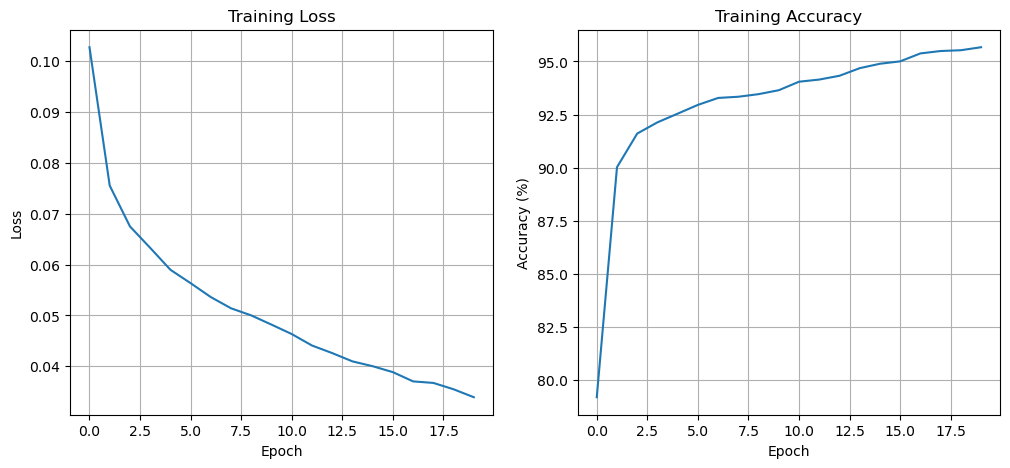

In [47]:
model.eval()
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad(): 
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        outputs = outputs.view(-1)
        predicted = (outputs > 0.5).float()
        
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


test_accuracy = 100 * test_correct / test_total
test_f1 = f1_score(all_labels, all_preds)

print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Test F1 Score: {test_f1:.4f}')

# Plot training metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()


##  1-D CNNs 

### Deep 1-D CNN Model 

In [48]:
# Create the BiLSTM model using nn.Module
class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        flattened_size = 32 * (F_train.shape[2] // 4)
        self.fc1 = nn.Linear(flattened_size, 64)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        if len(x.shape) == 3: 
            x = x.permute(0, 2, 1) 
        
        #forward pass through CNN layers
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

### Model, Loss Function, and Optimizer Definition

In [49]:
# Define model, loss function and optimizer
criterion = lambda yhat, y: mybce(yhat, y, pos_weight=7.5) 
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Device: {device}")

Device: cuda


### Train and Test Your Model

Epoch 1/20, Loss: 0.0330, Accuracy: 95.73%, F1: 0.8530
Epoch 2/20, Loss: 0.0316, Accuracy: 95.81%, F1: 0.8558
Epoch 3/20, Loss: 0.0306, Accuracy: 95.89%, F1: 0.8585
Epoch 4/20, Loss: 0.0299, Accuracy: 96.07%, F1: 0.8640
Epoch 5/20, Loss: 0.0287, Accuracy: 96.09%, F1: 0.8651
Epoch 6/20, Loss: 0.0289, Accuracy: 96.16%, F1: 0.8671
Epoch 7/20, Loss: 0.0280, Accuracy: 96.21%, F1: 0.8686
Epoch 8/20, Loss: 0.0280, Accuracy: 96.26%, F1: 0.8704
Epoch 9/20, Loss: 0.0269, Accuracy: 96.46%, F1: 0.8771
Epoch 10/20, Loss: 0.0265, Accuracy: 96.34%, F1: 0.8733
Epoch 11/20, Loss: 0.0262, Accuracy: 96.54%, F1: 0.8796
Epoch 12/20, Loss: 0.0262, Accuracy: 96.45%, F1: 0.8767
Epoch 13/20, Loss: 0.0256, Accuracy: 96.44%, F1: 0.8764
Epoch 14/20, Loss: 0.0252, Accuracy: 96.56%, F1: 0.8806
Epoch 15/20, Loss: 0.0249, Accuracy: 96.59%, F1: 0.8814
Epoch 16/20, Loss: 0.0251, Accuracy: 96.52%, F1: 0.8793
Epoch 17/20, Loss: 0.0241, Accuracy: 96.74%, F1: 0.8861
Epoch 18/20, Loss: 0.0249, Accuracy: 96.67%, F1: 0.8839
E

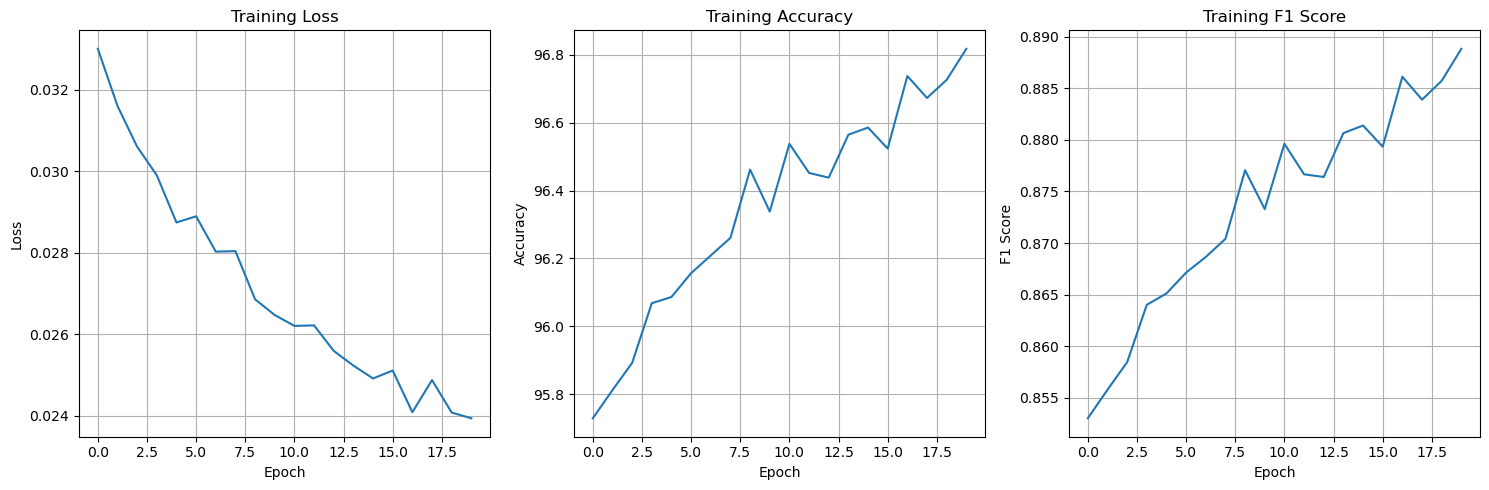

In [ ]:
# Training loop
num_epochs = 20
train_losses = []
train_accuracies = []
train_f1_scores = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_preds = []
    epoch_labels = []
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        outputs = outputs.view(-1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        epoch_preds.extend(predicted.cpu().numpy())
        epoch_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    epoch_f1 = f1_score(epoch_labels, epoch_preds)
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    train_f1_scores.append(epoch_f1)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, F1: {epoch_f1:.4f}')

#evaluate on test set
model.eval()
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        outputs = outputs.view(-1)
        predicted = (outputs > 0.5).float()
        
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
test_f1 = f1_score(all_labels, all_preds)

print(f'\nTest Accuracy: {test_accuracy:.2f}%')
print(f'Test F1 Score: {test_f1:.4f}')

#plotting the training progress
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(train_f1_scores)
plt.title('Training F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.grid(True)

plt.tight_layout()
plt.show()

### Difference btw LSTM and CNN

Answer: Architecturally, LSTM has an added temporal layer that lets it keep track of previous result and add the ability to sequency data while the CNN architecture is incapable of doing that(it only captures spatial patterns). but, looking at the results, in this case, CNN out-performed LSTM in this classification task.

##  AlexNet Implementation

![AlexNet](https://www.ncbi.nlm.nih.gov/corecgi/tileshop/tileshop.fcgi?p=PMC3&id=166618&s=150&r=1&c=1)

In [51]:
# Create the AlexNet model with appropriate adjustments for ECG data
class ECGAlexNet(nn.Module):
    def __init__(self):
        super(ECGAlexNet, self).__init__()
        _, seq_len, n_features = F_train.shape
        
        self.features = nn.Sequential(
            nn.Conv1d(in_channels=n_features, out_channels=96, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(in_channels=96, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv1d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv1d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
        )
        
        conv_output_length = seq_len // 8
        feature_output_size = 256 * conv_output_length
        
        #classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(feature_output_size, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


model = ECGAlexNet()

In [52]:
# Define loss function and optimizer
criterion = lambda yhat, y: mybce(yhat, y, pos_weight=7.5) 
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Device: {device}")

Device: cuda


### Train and Test Your AlexNet Model

Epoch 1/10, Loss: 0.0771, Accuracy: 84.22%, F1: 0.5750
Epoch 2/10, Loss: 0.0378, Accuracy: 95.44%, F1: 0.8442
Epoch 3/10, Loss: 0.0354, Accuracy: 96.09%, F1: 0.8641
Epoch 4/10, Loss: 0.0332, Accuracy: 96.20%, F1: 0.8681
Epoch 5/10, Loss: 0.0317, Accuracy: 96.11%, F1: 0.8659
Epoch 6/10, Loss: 0.0296, Accuracy: 96.45%, F1: 0.8767
Epoch 7/10, Loss: 0.0299, Accuracy: 96.44%, F1: 0.8763
Epoch 8/10, Loss: 0.0276, Accuracy: 96.59%, F1: 0.8814
Epoch 9/10, Loss: 0.0265, Accuracy: 96.60%, F1: 0.8821
Epoch 10/10, Loss: 0.0254, Accuracy: 96.84%, F1: 0.8898
Training Accuracy: 97.18%, F1: 0.9004
Test Accuracy: 89.73%, F1: 0.7619


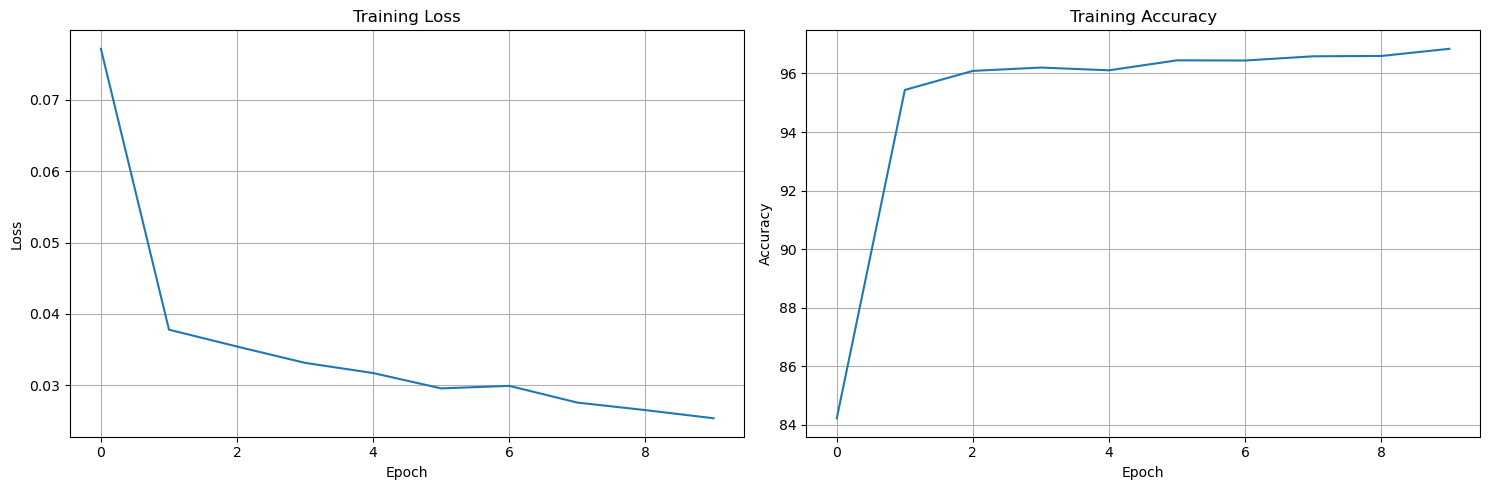

In [53]:
# Training loop
num_epochs = 10
train_losses = []
train_accuracies = []
train_f1_scores = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_preds = []
    epoch_labels = []
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.view(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        epoch_preds.extend(predicted.cpu().numpy())
        epoch_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    epoch_f1 = f1_score(epoch_labels, epoch_preds)
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    train_f1_scores.append(epoch_f1)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, F1: {epoch_f1:.4f}')

#evaluation on test set
model.eval()
train_correct = 0
train_total = 0
train_preds = []
train_true = []

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        outputs = outputs.view(-1)
        predicted = (outputs > 0.5).float()
        
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        train_preds.extend(predicted.cpu().numpy())
        train_true.extend(labels.cpu().numpy())

train_accuracy = 100 * train_correct / train_total
train_final_f1 = f1_score(train_true, train_preds)

test_correct = 0
test_total = 0
test_preds = []
test_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        outputs = outputs.view(-1)
        predicted = (outputs > 0.5).float()
        
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
        test_preds.extend(predicted.cpu().numpy())
        test_true.extend(labels.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
test_f1 = f1_score(test_true, test_preds)

print(f'Training Accuracy: {train_accuracy:.2f}%, F1: {train_final_f1:.4f}')
print(f'Test Accuracy: {test_accuracy:.2f}%, F1: {test_f1:.4f}')


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()